In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spotify-2023.csv', encoding='iso-8859-1')

# Clean Data
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')
df['key'] = df['key'].fillna('Unknown')
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(0)

# Fill NaNs with zero (not sure if necessary)
df.fillna(0, inplace=True)

# Ensure all columns have finite values
df.replace([float('inf'), float('-inf')], 0, inplace=True)



Data Preparation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Select features for the model
features = ['artist_count', 
            'in_spotify_playlists', 'in_spotify_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%',
            'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

X = df[features]
y = df['streams']  # Assuming we're predicting streams

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Implement XGBoost Regressor

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost Results:")
print(f"Mean Squared Error: {xgb_mse}")
print(f"R-squared Score: {xgb_r2}")

XGBoost Results:
Mean Squared Error: 7.936413236352522e+16
R-squared Score: 0.7070656632344112


Implement Support Vector Regression

In [5]:
from sklearn.svm import SVR

# Train SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Make predictions
svr_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
svr_mse = mean_squared_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

print("\nSVR Results:")
print(f"Mean Squared Error: {svr_mse}")
print(f"R-squared Score: {svr_r2}")


SVR Results:
Mean Squared Error: 3.072883206424686e+17
R-squared Score: -0.1342063186793312


In [6]:
print("\nModel Comparison:")
print(f"Random Forest R-squared: {0.7251625935723698}")  # Your original R-squared
print(f"XGBoost R-squared: {xgb_r2}")
print(f"SVR R-squared: {svr_r2}")


Model Comparison:
Random Forest R-squared: 0.7251625935723698
XGBoost R-squared: 0.7070656632344112
SVR R-squared: -0.1342063186793312


Feature Importance - Which Features are Most Important in the XGBoost model?

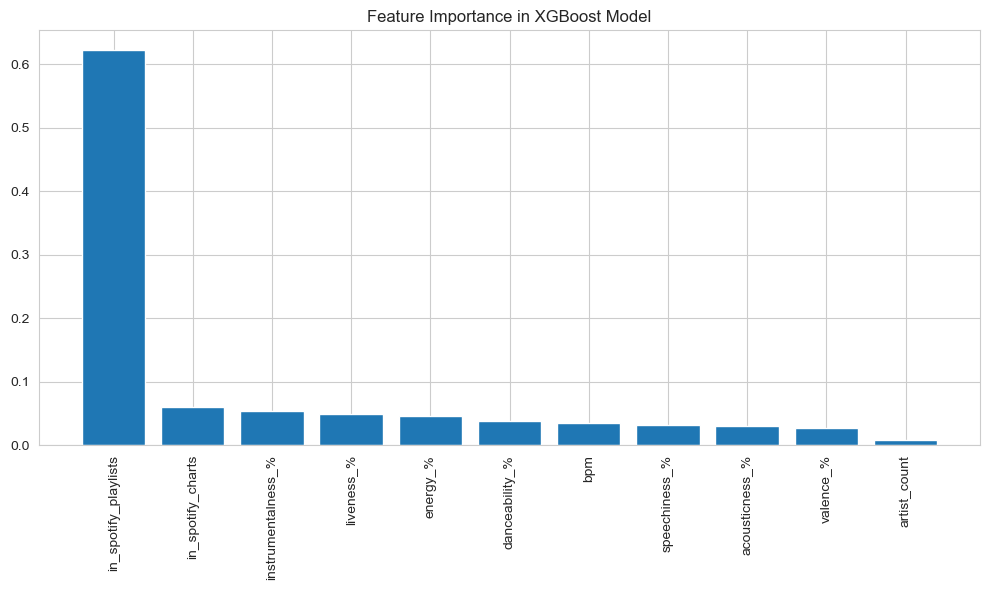

                 feature  importance
1   in_spotify_playlists    0.622450
2      in_spotify_charts    0.060268
8     instrumentalness_%    0.053371
9             liveness_%    0.049067
6               energy_%    0.045292
4         danceability_%    0.037425
3                    bpm    0.035098
10         speechiness_%    0.032509
7         acousticness_%    0.029621
5              valence_%    0.026517
0           artist_count    0.008381


In [7]:

# Get feature importance from XGBoost
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

print(feature_importance)

Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model to make predictions
best_xgb_pred = grid_search.best_estimator_.predict(X_test_scaled)
best_xgb_r2 = r2_score(y_test, best_xgb_pred)
print("Best XGBoost R-squared:", best_xgb_r2)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}
Best score: 0.7478101207698374
Best XGBoost R-squared: 0.6865034073956328


Learning Curves

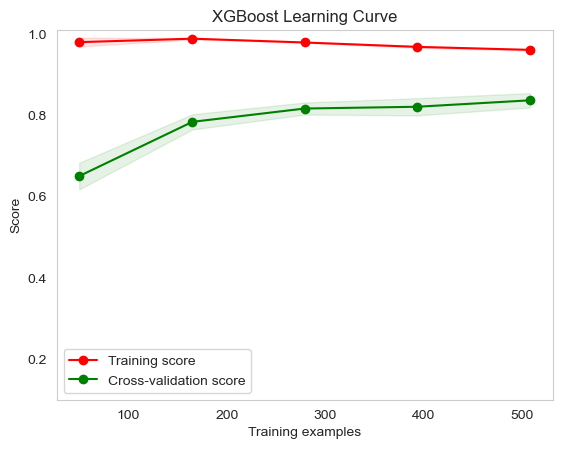

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(grid_search.best_estimator_, "XGBoost Learning Curve",
                    X_train_scaled, y_train, ylim=(0.1, 1.01), cv=3, n_jobs=-1)
plt.show()